In [1]:
import cv2
import numpy as np
import os
import csv
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [2]:
FOLDER = './images'
CSV = 'data annotations - Feuille 1.csv'

np.random.seed(42)
random.seed(42)
cv2.setRNGSeed(42)

In [8]:
def split(train=0.8, test=0.2, shuffle=True): # le ratio pour le test sert un peu a rien...
    images_names = []

    with open(CSV, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)

        # on ignore les 2 premieres ligens
        next(reader)
        next(reader)
        
        for row in reader:
            if len(row) < 2 or not row[0]:  # ignorer les lignes vides ou incompletes
                continue
            
            image_name = row[0]
            images_names.append(image_name)

    #print(f"Nombre total d'images : {len(images_names)}")

    split_id = int(len(images_names) * train)
    train_set = images_names[:split_id]
    test_set = images_names[split_id:]

    if shuffle:
        random.shuffle(train_set)
    
    return train_set, test_set

In [ ]:
def extract_features(image): # extraction de features pour le modele
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]
    max_size = 512
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        gray = cv2.resize(gray, (int(w * scale), int(h * scale)))
        h, w = gray.shape[:2]
    
    # 1 Contours et lignes Hough
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=40, maxLineGap=5)
    num_lines = 0
    mean_spacing = 0
    std_spacing = 0
    if lines is not None:
        horiz_y = []
        for x1, y1, x2, y2 in lines[:,0]:
            if abs(y2 - y1) < 0.2 * abs(x2 - x1):
                horiz_y.append((y1 + y2) / 2.0)
        horiz_y.sort()
        filtered_y = []
        min_sep = 0.03 * h  # 3% de la hauteur image
        for y in horiz_y:
            if not filtered_y or y - filtered_y[-1] > min_sep:
                filtered_y.append(y)
        num_lines = len(filtered_y)
        if num_lines >= 2:
            diffs = np.diff(filtered_y)
            mean_spacing = np.mean(diffs) / h
            std_spacing = np.std(diffs) / h

    # 2 Densite de contours
    edge_density = float(np.sum(edges > 0)) / (h * w)

    # 3 Profil vertical et pics
    profile = np.sum(edges, axis=1)  # somme des pixels de contours par ligne
    profile = cv2.blur(profile.reshape(-1,1), (5,1)).flatten()  # lissage
    deriv = np.diff(profile)
    peak_pos = 0
    peak_neg = 0
    for i in range(1, len(deriv)-1):
        if deriv[i] > deriv[i-1] and deriv[i] > deriv[i+1]:
            peak_pos += 1
        if deriv[i] < deriv[i-1] and deriv[i] < deriv[i+1]:
            peak_neg += 1
    peak_count = min(peak_pos, peak_neg)

    # 4 Ratio de gradients horizontaux
    hog = cv2.HOGDescriptor()
    hog_desc = hog.compute(gray)
    horiz_sum = 0
    total_sum = np.sum(hog_desc)
    for i in range(0, len(hog_desc), 9):
        horiz_sum += hog_desc[i] + hog_desc[i+8]
    horizontal_ratio = float(horiz_sum) / (total_sum + 1e-6)

    return np.array([num_lines, mean_spacing, std_spacing, peak_count, edge_density, horizontal_ratio])

In [15]:
class Dataset:
    def __init__(self):
        self.csv_file = self._load_csv()
    
    def _load_csv(self):
        csv_file = {}
        with open(CSV, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            next(reader)
            for row in reader:
                if len(row) >= 2 and row[0]:
                    csv_file[row[0]] = int(row[1])
        return csv_file
    
    def _augment(self, image, label): # pour 1 image on en creer 10
        augs = []
        h, w = image.shape[:2]
        for _ in range(10):
            angle = np.random.uniform(-5, 5)
            contrast = np.random.uniform(0.8, 1.2)
            brightness = np.random.uniform(-30, 30)
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
            rotated = cv2.warpAffine(image, M, (w,h))
            transformed = rotated.astype(np.float32)
            transformed = contrast * transformed + brightness
            transformed = np.clip(transformed, 0, 255).astype(np.uint8)
            augs.append((transformed, label))
        
        return augs
    
    def load(self, set, augment=False):
        features, labels = [], []
        
        for name in set:
            if name in self.csv_file:
                image = cv2.imread(os.path.join(FOLDER, name))
                if image is not None:
                    if augment:
                        for aug_img, label in self._augment(image, self.csv_file[name]):
                            features.append(extract_features(aug_img))
                            labels.append(label)
                    else:
                        features.append(extract_features(image))
                        labels.append(self.csv_file[name])

        return np.array(features), np.array(labels)

In [ ]:
class Model: # random forest avec grid search
    def __init__(self):
        self.pipeline = Pipeline([
            ('scaler', RobustScaler()),
            ('model', RandomForestRegressor(
                n_jobs=2,
                random_state=42,
                warm_start=True
            ))
        ])
        self.param_grid = {
            'model__n_estimators': [100, 200, 300, 400, 500],
            'model__max_depth': [None, 10, 15, 20],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['sqrt', 0.8],
            'model__bootstrap': [True, False]
        }
        
    
    def train(self, X, y):
        self.search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            cv=5,
            scoring='neg_mean_absolute_error',
            verbose=2,
            n_jobs=2 # pour aller un peu plus vite (pas -1 psk le cpu chauffe trop)
        )
        self.search.fit(X, y)
        print(f"Meilleurs parametres: {self.search.best_params_}")
        
    def evaluate(self, X, y):
        pred = self.search.predict(X)
        print(f"MAE: {mean_absolute_error(y, pred):.2f}")
        plt.figure(figsize=(12, 6))
        plt.scatter(y, pred, marker='x')
        plt.plot([0, y.max()], [0, y.max()], 'k--', label='Prediction parfaite')
        plt.xlabel('Vraies valeurs')
        plt.ylabel('Predictions')
        plt.show()

In [17]:
dataset = Dataset()
train, test = split()
X_train, y_train = dataset.load(train, augment=True)
X_test, y_test = dataset.load(test)


In [ ]:
# ca peut prendre du temps, faudrait le save
model = Model()
model.train(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Meilleurs parametres: {'model__bootstrap': False, 'model__max_depth': 10, 'model__max_features': 0.8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


MAE: 1.27


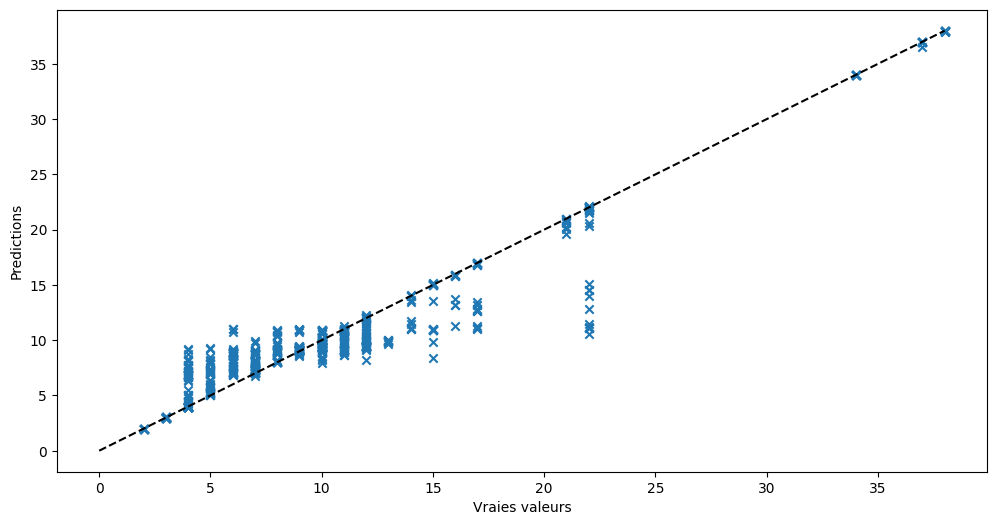

In [20]:
model.evaluate(X_train, y_train)

MAE: 2.96


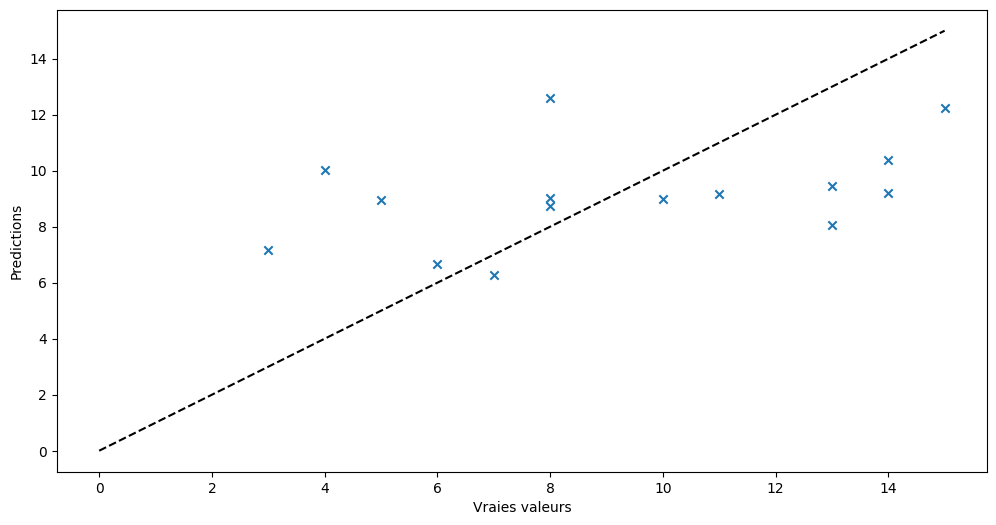

In [21]:
model.evaluate(X_test, y_test)